# Embedding Antibody Sequences using Sapiens

Try out this notebook in your browser: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Merck/Sapiens/main?labpath=notebooks%2F02_sapiens_antibody_embedding.ipynb)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
np.random.seed(42)
import re
np.random.seed(42)
tf.random.set_seed(42)
import pickle
import sys
import gc
import sapiens
from sklearn.manifold import TSNE

In [2]:
# from transformers import AdamWeightDecay, TFAutoModelForSequenceClassification, AutoTokenizer

# # model = sapiens.load_cached_model(model_dir, 'checkpoint_vh.pt')

# model = TFAutoModelForSequenceClassification.from_pretrained('v1', num_labels=2)

# model.compile(optimizer=AdamWeightDecay(2e-5), metrics=["accuracy"])
# model.summary()

## Get antibody embeddings

Get a vector representation of each position in a sequence

In [3]:
residue_embed = sapiens.predict_residue_embedding(
    "QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS", 
    "H", 
    layer=None # what does this do
)
residue_embed.shape
# (layer, position in sequence, features)

2023-01-02 12:48:55 | INFO | fairseq.file_utils | loading archive file /Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/sapiens/models/v1
2023-01-02 12:48:55 | INFO | fairseq.file_utils | loading archive file /Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/sapiens/models/v1
2023-01-02 12:48:57 | INFO | fairseq.tasks.masked_lm | dictionary: 24 types
2023-01-02 12:48:57 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 1000, 'log_format': 'simple', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': 'data/models/human_heavy_chain_by_year/seq_random20M/13_unmasked_700epochs/tensorboard', 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp

(5, 119, 128)

Get a single vector for each sequence

In [4]:
seq_embed = sapiens.predict_sequence_embedding(
    "QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS", 
    "H", 
    layer=None
)
seq_embed.shape
# (layer, features)

(5, 128)

In [5]:
# Sequence embedding from the last layer of our model
seq_embed[-1]

array([-9.07480791e-02,  9.95292738e-02,  4.42705542e-01,  1.76951751e-01,
        1.17761545e-01, -1.94502075e-03,  2.34257001e-02, -3.50218207e-01,
       -1.85383856e-01,  7.15081319e-02, -1.35001719e-01, -1.80759132e-01,
       -3.13717499e-03,  2.38733739e-02, -3.96349840e-02, -7.37676695e-02,
       -2.38686636e-01,  1.95218131e-01,  9.86457169e-02,  1.79552987e-01,
        3.17243300e-02, -3.33917588e-01, -8.63289684e-02, -5.02105765e-02,
       -7.52736256e-02,  1.59550109e-03, -4.97664243e-01, -1.65068477e-01,
       -4.22390401e-02,  2.61183560e-01, -2.77938396e-01, -1.29462048e-01,
       -1.64009873e-02,  4.70854566e-02,  5.25907613e-02,  8.33637826e-03,
       -4.97908801e-01,  7.72486776e-02,  7.08041430e-01, -3.29064220e-01,
        2.71839738e-01,  8.34675133e-02,  1.49200663e-01, -3.49690691e-02,
       -5.01605451e-01,  2.26801913e-02,  4.20484617e-02, -1.35063633e-01,
        5.07040648e-03, -2.95582205e-01,  1.43243209e-01, -1.41043007e-01,
       -3.53062041e-02, -

## Load Data

In [6]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
5,QITLKESGPTLVKPTQTLTLTCKLSGFSVNTGGVGVGWIRQPPGKA...
32,QVQLVQSGAEVKKPGSSVKVSCKASGDTFNIYAINWVRQAPGQGLE...
33,QVQLVQSGAEVKKPGSSVKVSCKASGGTFNSYAITWVRQAPGQGLE...
34,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTHGMHWVRQAPGKGLE...
35,QVQLVQSGAEVKKPGSSVKVSCKASGGTFRRYAISWVRQAPGQGLE...
...,...
11862,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
11863,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
11864,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
11865,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [7]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11415:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11415


In [8]:
del head
del myfile
del dummy
gc.collect()

6899

In [9]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [10]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [34]:
covid_sequence_embeddings = [sapiens.predict_sequence_embedding(i, chain_type="H", layer=-1) for i in covid_sequences]
print(np.shape(covid_sequence_embeddings))

(11415, 128)


In [35]:
healthy_sequence_embeddings = [sapiens.predict_sequence_embedding(i, chain_type="H", layer=-1) for i in healthy_sequences]
print(np.shape(covid_sequence_embeddings))

(11415, 128)


In [36]:
covid_residue_embeddings = [sapiens.predict_residue_embedding(i, chain_type="H", layer=-1) for i in covid_sequences]

In [37]:
healthy_residue_embeddings = [sapiens.predict_residue_embedding(i, chain_type="H", layer=-1) for i in healthy_sequences]

In [38]:
global_maxlen = 138 # this needs to be known a priori, from the max aa length block earlier

def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""

    Z = np.zeros((len(M), global_maxlen, 128))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] = row 
    return Z

In [39]:
covid_residue_embeddings = pad_to_dense(covid_residue_embeddings)
healthy_residue_embeddings = pad_to_dense(healthy_residue_embeddings)

In [40]:
healthy_lables = [0] * 11415
covid_lables = [1] * 11415

## Visualization

In [18]:
embeds = np.concatenate((covid_sequence_embeddings, healthy_sequence_embeddings))

In [19]:
%%time

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=10)
X_embedded = tsne.fit_transform(embeds)

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


CPU times: user 3min 32s, sys: 16.9 s, total: 3min 49s
Wall time: 1min 47s


In [20]:
all_sequences = np.concatenate((covid_sequences, healthy_sequences))
disease_labels = ['COVID'] * 11415 + ['Healthy'] * 11415

In [21]:
df = pd.DataFrame()
df.insert(0, 't-SNE 1', X_embedded[:,0])
df.insert(1, 't-SNE 2', X_embedded[:,1])
df.insert(2, 'Sequence', all_sequences)
df.insert(3, 'Disease Label', disease_labels)
df

,t-SNE 1,t-SNE 2,Sequence,Disease Label
0,-55.160702,47.868702,QVQLVQSGAEMKKPGASVKISCKASGDTFTTNYFHWVRQAPGQGLE...,COVID
1,-59.769585,-36.286121,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...,COVID
2,-82.820557,70.148895,QVQLVQSGAEVKKPGASVKVSCQASGATFTIYGFHWVRQAPGQGLE...,COVID
3,-4.952576,13.299580,EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,COVID
4,6.403134,-81.125786,QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...,COVID
...,...,...,...,...
22825,53.527332,-15.396211,TLSLTCAVSGYSINNAYFWGWIRQPPGGGLEWIGSLYHSGSTYYTP...,Healthy
22826,-81.738586,76.783020,EVQLVESGTEVKKPGASVKVSCKTSGYTFKSYGIIWVRQAPGQGLE...,Healthy
22827,44.145439,-50.679314,RQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLEW...,Healthy
22828,107.958931,11.459100,WSLRLSCAASGFTFSDYYMTWIRQAPGKGLEWVSYISGSNSFINYG...,Healthy


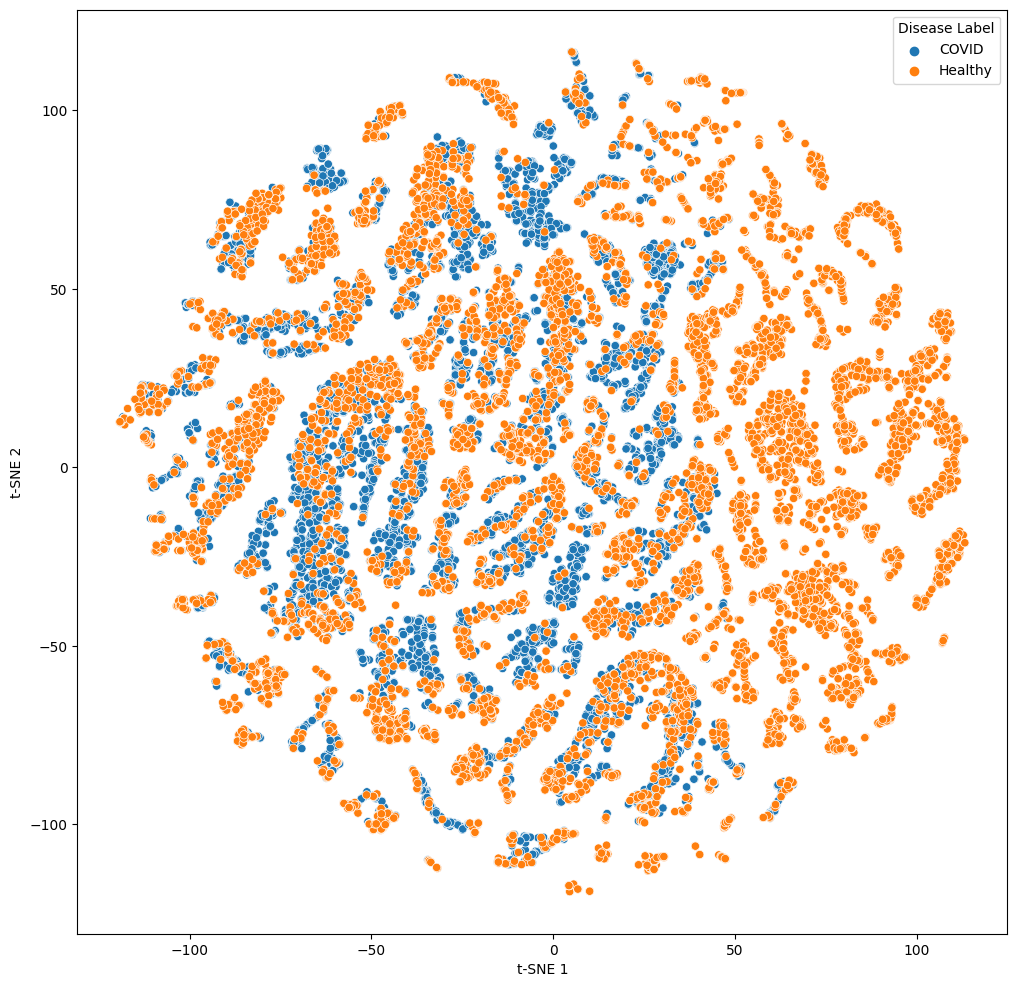

In [35]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    hue="Disease Label",
    data=df,
    legend="full"
)
plt.show()

In [36]:
# An SVM would be really terrible at this

# Model 1

In [41]:
X = np.concatenate((healthy_residue_embeddings, covid_residue_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [42]:
del healthy_residue_embeddings
del covid_residue_embeddings
gc.collect()

44166

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [44]:
# del X
# del y
# gc.collect()

In [45]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [63]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(138, 1024)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.summary()

# Change stuff here

model = tf.keras.models.Sequential([
  # tf.keras.layers.Conv2D(64, (6, 6), activation='relu', input_shape=(138, 128, 1)),
  # tf.keras.layers.MaxPooling2D((3,3), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
  # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # tf.keras.layers.BatchNormalization(),

  # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  # # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # # tf.keras.layers.BatchNormalization(),

  # # tf.keras.layers.Conv2D(16, (2, 2), activation='relu'),
  # # tf.keras.layers.MaxPooling2D((2,2), padding='same'),
  # # tf.keras.layers.BatchNormalization(),

  # # tf.keras.layers.Flatten(),

  tf.keras.layers.Input((138, 128)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM((256), return_sequences=True)),

  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),

  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_17 (Bidirecti  (None, 138, 512)         788480    
 onal)                                                           
                                                                 
 dropout_33 (Dropout)        (None, 138, 512)          0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 512)              1574912   
 onal)                                                           
                                                                 
 dense_80 (Dense)            (None, 512)               262656    
                                                                 
 dense_81 (Dense)            (None, 256)               131328    
                                                                 
 dropout_34 (Dropout)        (None, 256)             

In [64]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [65]:
history = model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/50


2023-01-02 13:49:01.743750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:49:02.279880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:49:02.307621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:49:03.503816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:49:03.524317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:49:04.209741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:49:04.242810: I tensorflow/core/grappler/optimizers/cust

578/578 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.7489

2023-01-02 13:50:43.929404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:50:44.094693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:50:44.175823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:50:44.530965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 13:50:44.546527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - 113s 183ms/step - loss: 0.4664 - accuracy: 0.7489 - val_loss: 0.4170 - val_accuracy: 0.7903
Epoch 2/50
578/578 [==============================] - 100s 172ms/step - loss: 0.3974 - accuracy: 0.8009 - val_loss: 0.3886 - val_accuracy: 0.8229
Epoch 3/50
578/578 [==============================] - 88s 153ms/step - loss: 0.3658 - accuracy: 0.8277 - val_loss: 0.3668 - val_accuracy: 0.8141
Epoch 4/50
578/578 [==============================] - 86s 149ms/step - loss: 0.3518 - accuracy: 0.8338 - val_loss: 0.3511 - val_accuracy: 0.8482
Epoch 5/50
578/578 [==============================] - 86s 149ms/step - loss: 0.3385 - accuracy: 0.8425 - val_loss: 0.3368 - val_accuracy: 0.8433
Epoch 6/50
578/578 [==============================] - 87s 150ms/step - loss: 0.3328 - accuracy: 0.8471 - val_loss: 0.3345 - val_accuracy: 0.8496
Epoch 7/50
578/578 [==============================] - 87s 150ms/step - loss: 0.3238 - accuracy: 0.8510 - val_loss: 0.3222 - val_accuracy: 0

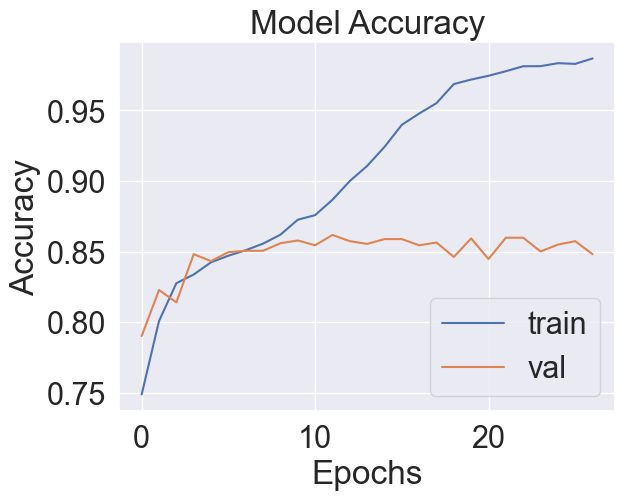

In [66]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 1 Testing

In [67]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 8s 108ms/step - loss: 0.3248 - accuracy: 0.8559


[0.32484176754951477, 0.8558914065361023]

In [68]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

2023-01-02 14:37:40.308448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:37:40.478014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:37:40.495973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:37:40.852536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 14:37:40.868209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 106ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

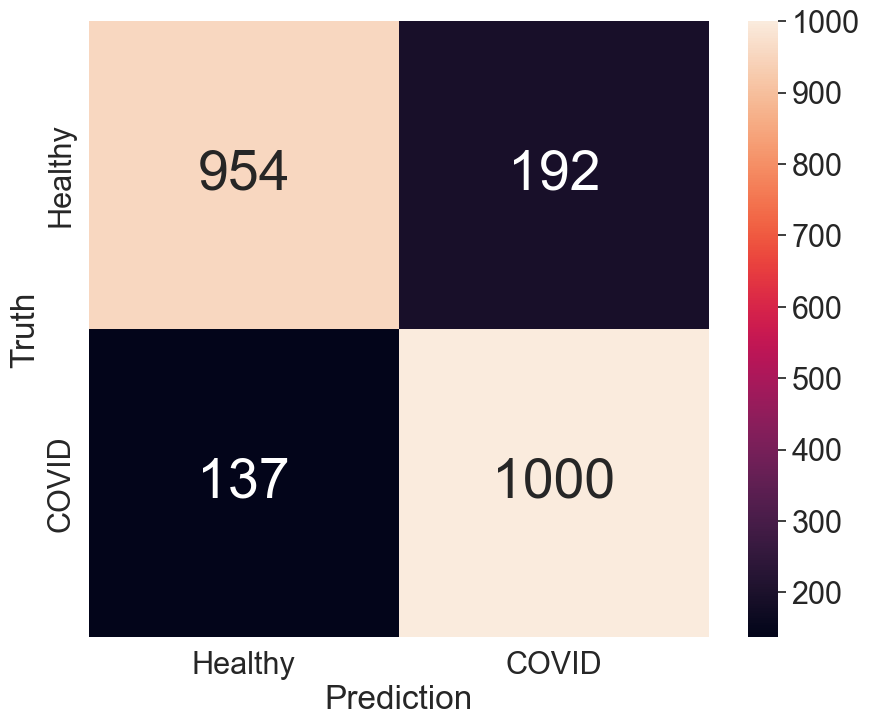

tf.Tensor(
[[ 954  192]
 [ 137 1000]], shape=(2, 2), dtype=int32)


In [69]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [70]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

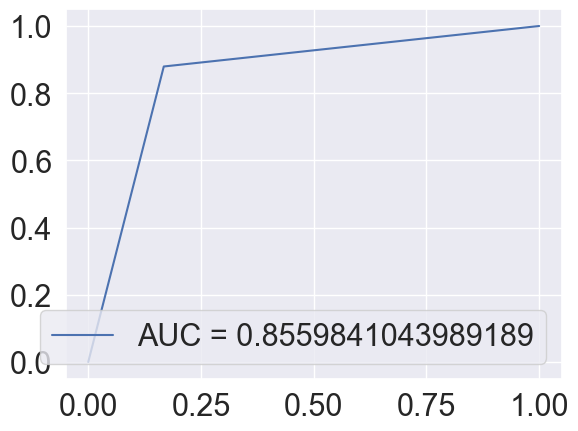

In [71]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
import os
os._exit(00)

: 

: 